** Módulo de Herramientas de Análisis - Python **

** Máster en Data Science UAH **

Roberto Santamaría Ayuso

Dataset escogido: base de datos de comercio internacional de la ONU, disponible en https://comtrade.un.org/data/doc/api/


---

**NOTA**: la API de Comtrade impone límites que fuerzan a que la descarga de datostarde entre 1 y 2 horas. Este notebook incluye el código para la descarga y consolidación de datos, pero ofrece la posibilidad de descargar los ficheros, ya limpios y consolidados, desde Dropbox.

Puede cambiar el siguiente flag para forzar la descarga de todos los ficheros.

---

In [438]:
# por defecto, descargar ficheros ya consolidados y limpios desde Dropbox
# cambiar a True para ejecutar las llamadas a la API
get_data_from_API = False
tradefile_ready = "https://www.dropbox.com/s/brssjrh2vj1tnlw/trade2015.csv?dl=0"
availabilityfile_ready = "https://www.dropbox.com/s/msia9osjd7l9j6n/comtrade_availability.csv?dl=0"
metadatafile_ready = "https://www.dropbox.com/s/bdd250jgicwdk3k/wb_countries_metadata.csv?dl=0"

## Resumen
En este notebook vamos a analizar datos de comercio internacional recolectados por la ONU. Estos datos son enviados por los países al *Department of Economic and Social Affairs* (DESA), una agencia dependiente de la ONU. Se pueden consultar agregados por mes y por año, y agrupados en diversos niveles jerárquicos de bienes y servicios. La jerarquía es compleja y no todos los países informan con el mismo grado de precisión, lo que limita la disponibilidad de datos para ciertos bienes y servicios. La API REST permite consultas gratuitas con ciertas limitaciones que hay que tener en cuenta a la hora de descargar los datos.

En primer lugar plantearemos preguntas con las que enfocar el análisis del dataset. A continuación, descargaremos los datos con la API, los consolidaremos y los limpiaremos. En el siguiente paso trataremos de contestar las preguntas transformando los datos, y acabaremos con algunas visualizaciones que ayuden a entender los resultados.

## Planteamiento

La información sobre comercio internacional ayuda a entender las relaciones entre países, el poder económico de los mismos y, de una manera global, los movimientos mercantiles a nivel mundial. Los datos ofrecidos por la DESA son exhaustivos, llegando al detalle por mes, por categoría e incluso por provincias o regiones en algunos casos. Las categorías son tan dispares como *Edible fruit and nuts; peel of citrus fruit or melons* o *Aluminium and articles thereof*, y cubren tanto bienes materiales como servicios.

Con estos datos podemos abordar cuestiones como:
- ¿Hay países principalmente exportadores, o principalmente importadores?
- ¿Los intercambios comerciales se concentran en áreas geográficas cercanas?
- ¿Hay países que monopolizan la exportación de ciertos bienes?

El análisis de estos datos presenta ciertas dificultades inherentes a la recopilación de los mismos: 
- Aunque un único agente agrega los datos, cada país es responable de enviar los datos. En algunos casos los datos son reportados años más tarde de cuando fueron producidos.
- La jerarquía de categorías se divide en 6 niveles, pero no todos los países reportan al mayor nivel de detalle. Por ejemplo, la primera división en el primer nivel de la jerarquía es *LIVE ANIMALS; ANIMAL PRODUCTS*. Ésta se subdivide en 5 categorías, entre ellas *Live Animals*. Ésta, a su vez, se subdivide en dos niveles más hasta llegar a una categoría de *Live poultry* > *Weighing no more than 185 g* > *Guinea fowls*. Algunos países reportan con el máximo detalle, pero otros se limitan al primero o segundo nivel de la jerarquía. El detalle completo se puede consultar eh http://www.wcoomd.org/en/topics/nomenclature/instrument-and-tools/hs-nomenclature-2017-edition/hs-nomenclature-2017-edition.aspx.

Además, la API de Comtrade impone ciertos límites:
- Cada petición está limitada a 50.000 entradas (o líneas de CSV).
- No se pueden realizar más de 100 peticiones por hora ni más de 1 petición por segundo.




## Inicialización

Cargamos las librerías que necesitaremos a lo largo del notebook.

In [2]:
import requests as rq
import pandas as pd
import numpy as np
from io import StringIO
import json
import time
import seaborn as sns

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

print("Pandas version:", pd.__version__)
print("Requests version:", rq.__version__)
print("Numpy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)

Pandas version: 0.20.3
Requests version: 2.18.4
Numpy version: 1.13.3
Matplotlib version: 2.1.0
Seaborn version: 0.8.0


## Descarga de datos

En primer lugar vamos a identificar un año sobre el que dispongamos de suficiente información. Comtrade dispone de una consulta sobre disponibilidad de datos en https://comtrade.un.org/data/da. Vamos a descargar los datos de y obtener cuál es el último año sobre el que han informado los países.

In [3]:
if get_data_from_API:
    availability_url = 'https://comtrade.un.org/api/refs/da/view?fmt=csv'
    availability_resp = rq.get(availability_url)

    # la API devuelve un CSV en el cuerto de la resputa
    # inicializamos un dataframe desde esta string, sin escribir en disco
    availability_df = pd.read_csv(StringIO(availability_resp.text))
    availability_df.to_csv("comtrade_availability.csv", index=False)
else:
    availability_df = pd.read_csv("comtrade_availability.csv")

availability_df.head()

,type,freq,px,r,rDesc,ps,TotalRecords,isOriginal,publicationDate,isPartnerDetail
0,COMMODITIES,ANNUAL,BEC,100,Bulgaria,1998,4325,0,2005-06-20T00:00:00,1
1,COMMODITIES,ANNUAL,BEC,100,Bulgaria,1999,4371,0,2005-06-20T00:00:00,1
2,COMMODITIES,ANNUAL,BEC,100,Bulgaria,2000,5253,0,2014-12-12T00:00:00,1
3,COMMODITIES,ANNUAL,BEC,100,Bulgaria,2001,5494,0,2014-12-12T00:00:00,1
4,COMMODITIES,ANNUAL,BEC,100,Bulgaria,2002,5664,0,2014-12-12T00:00:00,1


In [4]:
# filtramos los datos de bienes materiales y con frecuencia anual
# después agrupamos por país (rDesc) y año (ps)
# acabamos agrupando por año y contamos cuántos países han reportado cada año

countries_reported_by_year_df = (
    availability_df[((availability_df['type'] == 'COMMODITIES') & (availability_df['freq'] == 'ANNUAL'))]
    .groupby(by=["rDesc", "ps"], as_index=False)
    .count()
    .groupby(by="ps", as_index=False)
    .count()[["ps", "rDesc"]]
    .sort_values(by="ps", ascending=False)
)


countries_reported_by_year_df.head()

,ps,rDesc
54,2016,140
53,2015,153
52,2014,159
51,2013,165
50,2012,170


Hay 140 países que han reportado datos hasta 2016. En 2015 disponemos de datos de 163 países, en 2014, de 167, etc. Estos números reflejan que el dataset es sólo relativamente fiable, ya que hay más de 190 países en el mundo y sólo tenemos información actualizada de menos de 170.

Un valor de compromiso es analizar los datos de 2015.

---

La descarga de datos está condicionada por las limitaciones de la API. Para no llegar al límite de registros por petición, haremos una petición por país. Controlaremos los tiempos entre peticiones y los errores que pueda devolvernos la API si sobrepasamos el límite para automatizar la descarga. El resultado será un fichero CSV por país. Una vez dispongamos de todos los ficheros, consolidaremos todos los ficheros en uno.

A continuación configuramos los parámetros de las peticiones de la API. LA documentación está disponible en https://comtrade.un.org/data/doc/api/#DataRequests.

In [5]:
# configuración inicial: datos de 2015, agregados por año

base_url = 'https://comtrade.un.org/api/get'

params = {
    'ps': '2015', # período: puede ser un año '2015', un mes '201301' o 'recent' para los 5 últimos
    'freq': 'A', # Anual o Mensual
    'px': 'HS', # código de clasificación; Harmonized System es el más estándar
    'r': '', # país origen de la transacción 
    'p': 'all', # país destino de la transacción
    'rg': 'all', # dirección de la trasacción: importación (1), exportación (2) o ambos (all)
    'cc': 'AG2', # nivel de la jerarquía
    'type': 'C', # tipo: bienes materiales (C) o servicios (S)

    'fmt': 'csv', # formato de salida: csv o json
    'head': 'M', # encabezados amigables para humanos (H) o para máquinas (M)
    'max': '50000' # número máximo de registros; 50000 es el máximo para consultas gratuitas
}

# se pueden solicitar encabezados "amistosos" para humanos o para máquinas (sin espacios, paréntesis, etc.)
# agrupamos ambos en un diccionario como referencia
headersM = """pfCode,yr,period,periodDesc,aggrLevel,IsLeaf,
              rgCode,rgDesc,rtCode,rtTitle,rt3ISO,ptCode,
              ptTitle,pt3ISO,ptCode2,ptTitle2,pt3ISO2,cstCode,
              cstDesc,motCode,motDesc,cmdCode,cmdDescE,qtCode,
              qtDesc,qtAltCode,qtAltDesc,TradeQuantity,AltQuantity,
              NetWeight,GrossWeight,TradeValue,CIFValue,FOBValue,estCode""".split(sep=",")
headersH = """Classification,Year,Period,Period Desc.,Aggregate Level,
              Is Leaf Code,Trade Flow Code,Trade Flow,Reporter Code,
              Reporter,Reporter ISO,Partner Code,Partner,Partner ISO,
              2nd Partner Code,2nd Partner,2nd Partner ISO,
              Customs Proc. Code,Customs,Mode of Transport Code,
              Mode of Transport,Commodity Code,Commodity,Qty Unit Code,
              Qty Unit,Qty,Alt Qty Unit Code,Alt Qty Unit,Alt Qty,
              Netweight (kg),Gross weight (kg),Trade Value (US$),
              CIF Trade Value (US$),FOB Trade Value (US$),Flag""".split(sep=",")

headersM = map(str.strip, headersM)
headersH = map(str.strip, headersH)
headers = dict(zip(headersM, headersH))

El filtro por país de la API requiere un código numérico propio. Podemos obtenerlo de la tabla de disponibilidad de datos que utilizamos en el primer apartado, filtrado los datos anuales de 2015.

In [6]:
country_codes = (availability_df[ ((availability_df['type'] == 'COMMODITIES') 
                                & (availability_df['freq'] == 'ANNUAL')
                                & (availability_df['ps'] == 2015))]
                               [['rDesc', 'r']]
                                .drop_duplicates())
print("Número de países:", country_codes.shape[0])
country_codes.head()

Número de países: 153


,rDesc,r
17,Bulgaria,100
24,Myanmar,104
43,Burundi,108
61,Belarus,112
78,Cambodia,116


Ya podemos descargar los datos de cada país. Para ellos vamos a hacer un bucle sobre todos los códigos de país, haciendo una petición a la API para cada código. La descarga puede tardar un par de horas debido al límite de 100 peticiones por hora. Descargaremos los CSV a un directorio temporal para evitar reiniciar la descarga en caso proglemas en la red o en el kernel.

In [69]:
if get_data_from_API:
    folder = "trade2015"
    !mkdir -p {folder}

    # límite por hora: código 401 y mensaje "USAGE LIMIT: Hourly usage limit of 100 actions reached. You may resume use of this service at 2018-01-09T12:51:25Z."
    # límite por segundo: código 401 y mensaje "

    # aprox. 250 MB en 153 archivos

    i = 0
    max_retries = 60 # en caso de error lo intentamos otra vez hasta este máximo 
    retries = 0
    wait_errors = 60 # esperamos 1 minuto entre errores; los errores occuren por hacer demasiadas peticiones por hora
    while i < country_codes.shape[0]:
        name, code = country_codes.iloc[i] 
        fileExists = !ls {folder}/{code}.csv
        if ('cannot' not in fileExists[0]):
            print("Already have data for", name)
            i += 1
            retries = 0
            continue
        print("Getting data for", name)
        params['r'] = code
        response = rq.get(base_url, params=params)
        if (response.status_code != 200):
            print("Error downloading last country, retrying... (", response.text, ")")
            retries += 1
            if retries >= max_retries:
                print("Too many errors; examine the error message and run again")
                print(response.text)
                break
            else:
                time.sleep(wait_errors)
        else:
            print("\tReceived", len(response.text),"bytes.")
            f = open(folder + "/" + str(code) + ".csv", "w")
            f.write(response.text)
            f.close()
            time.sleep(1)
            i += 1
            retries = 0

Already have data for Bulgaria
Already have data for Myanmar
Already have data for Burundi
Already have data for Belarus
Already have data for Cambodia
Already have data for Algeria
Already have data for Cameroon
Already have data for Canada
Already have data for Cabo Verde
Already have data for Cayman Isds
Already have data for Central African Rep.
Already have data for Sri Lanka
Already have data for Chile
Already have data for China
Already have data for Colombia
Already have data for Costa Rica
Already have data for Croatia
Already have data for Cyprus
Already have data for Czechia
Already have data for Benin
Already have data for Denmark
Already have data for Dominican Rep.
Already have data for Ecuador
Already have data for El Salvador
Already have data for Ethiopia
Already have data for Estonia
Already have data for Angola
Already have data for Fiji
Already have data for Finland
Already have data for France
Already have data for French Polynesia
Already have data for Georgia
Alr

Una vez descargados los datos de cada país, podemos consolidarlos en un único dataframe. En el mismo paso seleccionaremos sólo las columnas de interés. Finalmente guardaremos el dataframe en un CSV para poder reanudar el análisis sin necesidad de descargar o consolidar todos los ficheros de nuevo.



In [86]:
if get_data_from_API:
    files = !ls {folder}
    dfs = []
    for f in files:
        df = pd.read_csv(folder + "/" + f)
        df = df[["rtTitle", "rt3ISO", "rtCode", "rgDesc", "ptTitle", "pt3ISO", "ptCode", "pfCode", "period","TradeValue", "cmdDescE", "cmdCode"]]
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
    df.rename(columns={"rtTitle": "Source", "rt3ISO": "SourceISO", "ptTitle": "Destination", "pt3ISO": "DestinationISO", 
                       "rgDesc": "Direction", "period": "Year", "cmdDescE": "Description", "cmdCode": "CommodityCode"},
              inplace=True)

    print("Número de registros:",df.shape[0])
    print("Número de países:",len(pd.unique(df['Source'])))
    df.head()

Número de registros: 1453667
Número de países: 153


Algunos registros no corresponden a países sino a regiones como *World* o *EU-28*. Si bien estos datos agregados pueden ser de interés, inicialmente vamos a centrarnos en las relaciones entre países individuales. Para ellos, vamos a eliminar los registros de estas regiones. Eliminaremos además los registros con NA, ya que nos impedirán progresar en el análisis.

In [87]:
if get_data_from_API:
    skip_regions = ['Other Asia, nes',
                    'EU-28',
                    'World',
                    'Areas, nes',
                    'Other Africa, nes',
                    'Oceania, nes',
                    'LAIA, nes',
                    'North America and Central America, nes',
                    'Free Zones',
                    'Special Categories']

    num_reg = df.shape[0]
    df = df[(~df['Source'].isin(skip_regions))]
    df = df[(~df['Destination'].isin(skip_regions))]
    df = df[(df['Direction'] == 'Export') | (df['Direction'] == 'Import')]
    num_reg_skip = df.shape[0]
    df.dropna(axis=0, how='any', inplace=True)
    num_reg_na = df.shape[0]
    print("Registros en zonas especiales:", str(num_reg-num_reg_skip))
    print("Registros con NA:", str(num_reg_skip-num_reg_na))
    print("Registros útiles:",num_reg_na)

Registros en zonas especiales: 170437
Registros con NA: 3234
Registros útiles: 1279996


Otro campo que puede generar errores durante el análisis es *Description*. Si bien las descripciones de los bienes siguen una jerarquía más o menos escricta, hay discrepancias las cadenas de texto. Por ejemplo, hay 3 descriptiones diferentes para la categoría de paraguas. Todas usan el mismo código de categoría, pero tienes uno o más caracteres diferentes.

In [355]:
pd.unique(df[df['CommodityCode'] == 66]["Description"])

array([ 'Umbrellas, sun umbrellas, walking-sticks, seat-sticks, whips, riding-crops and parts thereof',
       'Umbrella, sun umbrellas, walking-sticks, seat-sticks, whips, riding-crops and parts thereof',
       'Umbrellas, sun umbrellas, walking sticks, seat sticks, whips, riding-crops'], dtype=object)

Vamos a limpiar estos datos manteniendo una única descripción por código. Las descriptiones son prácticamente idénticas, así que, para cada código, asignaremos la primera descripción que encontremos en el dataframe. Con esto generaremos un dataframe auxiliar que posteriormente cruzaremos con el dataframe original, descartando las descripciones originales y manteniendo las nuevas.

In [356]:
# extraemos los valores únicos de códigos de bienes, y para cada uno, extraemos la primera descripción que 
# encontramos. Con esto tenemos un dataframe auxiliar
if get_data_from_API:
    commodity_codes = pd.unique(df['CommodityCode'])
    descriptions = [df[df['CommodityCode'] == code].iloc[0]['Description']  for code in commodity_codes]
    commodities = pd.DataFrame({"Code": CommodityCodes, "Description": Descriptions})
    commodities.head()

,Code,Description
0,1.0,Live animals
1,2.0,Meat and edible meat offal
2,3.0,"Fish and crustaceans, molluscs and other aquat..."
3,4.0,Dairy produce; birds' eggs; natural honey; edi...
4,5.0,"Products of animal origin, not elsewhere speci..."


In [357]:
# descargamos las descripciones originales y usamos las de la tabla auxiliar
if get_data_from_API:
    del df['Description']
    df = df.merge(commodities,
                  how='inner',
                  left_on="CommodityCode",
                  right_on="Code")
    del df['Code']

Finalmente, escribimos los datos, ya limpios, a un fichero intermedio. Como se ha explicado arriba, si hemos desactivado la descarga desde la API, leemos los datos directamente del fichero.

In [88]:
if get_data_from_API:
    df.to_csv("trade2015.csv", index=False)
else:
    df = pd.read_csv("trade2015.csv")

## Análisis

Ahora que tenemos un dataset consolidado y limpio podemos atacar las preguntas que nos hemos planteado.

### ¿Hay países principalmente exportadores, o principalmente importadores?

Un concepto habitual en los análisis macroeconómicos es la balanza comercial. Se define como la diferencia entre exportaciones e importaciones, de manera que una balanza positiva indica que un país vende más bienes de los que importa. Aquí manejamos una versión simplificada, ya que no estamos teniendo en cuenta servicios ni transferencias financieras ni de divisas.

A continuación agrupamos el dataframe por país y dirección de la transferencia, y calculamos la balanza comercial según hemos definido. También calculamos el valor de la balanza como proporción de las exportaciones, ya que hay un rango de valores muy amplio.

In [89]:
df_grp = df.groupby(by=["Source", "Direction"], as_index=False).sum()
df_grp = df_grp[["Source", "Direction", "TradeValue"]]
df_grp = df_grp.pivot(index="Source", columns='Direction',values='TradeValue')
df_grp.fillna(value=0, inplace=True)
df_grp['Balance'] = df_grp['Export'] - df_grp['Import']
df_grp['BalanceNorm'] = df_grp['Balance'] / df_grp['Export']

En primer lugar, comprobamos si hay exportadores o importadores netos. Vemos que las *Islas Caimán* aparecen como un importador neto - es un resultado razonable, ya que es un país muy pequeño dedicado principalmente a los servicios financieros. Por otro lado, Iraq aparece como exportador neto. Es probable que este valor esté falseado y que el país no haya informado del valor real porque ha sufrido sanciones comerciales.

In [90]:
df_grp[(df_grp['Export'] == 0) | (df_grp['Import'] == 0)]

Direction,Export,Import,Balance,BalanceNorm
Source,,,,
Cayman Isds,0.0,915454391.0,-915454391.0,-inf
Iraq,191282280.0,0.0,191282280.0,1.000000


Para el resto del análisis eliminamos estos últimos valores. Además calculamos los países con las balanzas más desequilibradas, tanto en valor absoluto como en relativo.

In [91]:
df_grp = df_grp[(df_grp['Export'] != 0) & (df_grp['Import'] != 0)]

top1Abs = df_grp.sort_values(by='Balance', ascending=False).iloc[0]
bottom1Abs = df_grp.sort_values(by='Balance', ascending=True).iloc[0]
top1Norm = df_grp.sort_values(by='BalanceNorm', ascending=False).iloc[0]
bottom1Norm = df_grp.sort_values(by='BalanceNorm', ascending=True).iloc[0]

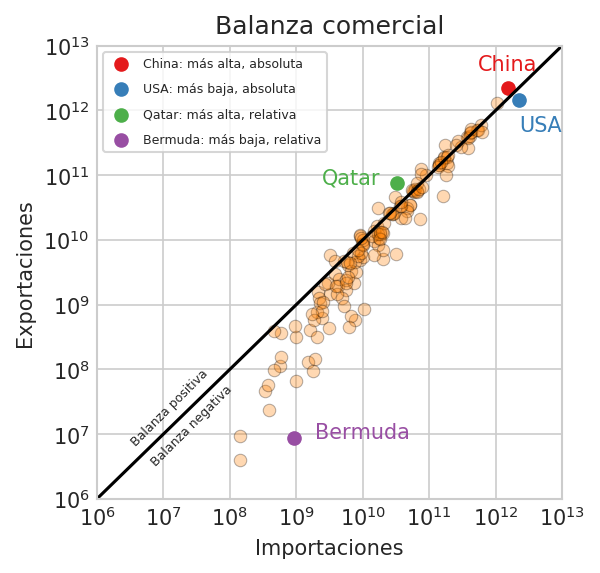

In [92]:
# paleta obtenida en http://colorbrewer2.org/?type=qualitative&scheme=Set1&n=5
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']

plt.figure(figsize=(4, 4), dpi=150);
ax = plt.axes(xscale='log', yscale='log');
plt.xlim(1e6,1e13)
plt.ylim(1e6,1e13);
plt.title("Balanza comercial")
plt.xlabel("Importaciones")
plt.ylabel("Exportaciones")


plt.scatter(df_grp.Import,
            df_grp.Export,
            label="_skip",
            color=colors[4], 
            linewidths=0.5,
            edgecolors="black",
            alpha=0.3)

# indicamos dónde está el punto de equilibrio
plt.plot([1e6, 1e14], [1e6, 1e14], color="black")
ax.text(3e6, 6e6,
        "Balanza positiva", 
        {'ha': 'left', 'va': 'bottom', 'size': 6},
        rotation=45)

ax.text(6e6, 3e6,
        "Balanza negativa", 
        {'ha': 'left', 'va': 'bottom', 'size': 6},
        rotation=45)

ax.scatter(top1Abs.Import, top1Abs.Export, label=top1Abs.name + ": más alta, absoluta", color=colors[0])
ax.text(top1Abs.Import-1e12, top1Abs.Export+2e12, top1Abs.name, dict(size=10, color=colors[0]))
ax.scatter(bottom1Abs.Import, bottom1Abs.Export, label=bottom1Abs.name + ": más baja, absoluta", color=colors[1])
ax.text(bottom1Abs.Import, bottom1Abs.Export-1e12, bottom1Abs.name, dict(size=10, color=colors[1]));


ax.scatter(top1Norm.Import, top1Norm.Export, label=top1Norm.name + ": más alta, relativa", color=colors[2])
ax.text(top1Norm.Import-3e10, top1Norm.Export, top1Norm.name, dict(size=10, color=colors[2]))
ax.scatter(bottom1Norm.Import, bottom1Norm.Export, label=bottom1Norm.name + ": más baja, relativa", color=colors[3])
ax.text(bottom1Norm.Import+1e9, bottom1Norm.Export, bottom1Norm.name, dict(size=10, color=colors[3]));


plt.legend(scatterpoints=1, frameon=True,
           labelspacing=1, title='',
           loc="upper left", ncol=1,
           prop={'size': 6}, );

Hay que advertir que el gráfico anterior está en escala logarítmica, ya que el rango de valores es extremadamente amplio: desde 10 millones hasta más de 1.5 billones. La línea recta indica los valores de una balanza equilibrada, con un valor similar de exportaciones e importaciones. Se observa que los países se mueven en ese rango, si bien la mayoría tienen un déficit de exportaciones. El país con mayor desequilibrio respecto a sus exportaciones totales es Bermuda; tiene sentido ya que, al igual que las Islas Caimán, es un centro financiero y un destino turístico. Los países con la balanza más desequilibrada en valor absoluto son también los dos con el mayor volumen de exportaciones e importaciones: China y Estados Unidos. China es un consigue exportar más materias primas y bienes manufacturados de los que importa, mientras que Estados Unidos necesita importar más de lo que exporta.

### ¿Los intercambios comerciales se concentran en áreas geográficas cercanas?

Podemos pensar que, en un mundo globalizado, el intercambio de bienes no tiene fronteras. Esto podemos comprobarlo simplemente entrando en un supermercado pero ¿es el comercio con los países vecinos aún predominante? 

Para este análisis vamos a utilizar datos auxiliares proporcionados por el World Bank. Esta entidad ofrece datos de una gran variedad de datos económicos, pero sólo descargaremos unos metadatos que nos indican la zona geográfica de cada país.

In [93]:
if get_data_from_API:
    # documentación de la API en https://datahelpdesk.worldbank.org/knowledgebase/articles/902049
    wb_url = 'http://api.worldbank.org/v2/countries/?format=json&per_page=500'
    response = rq.get(wb_url)
    wb_md = json.loads(response.text)

    # transformamos el JSON en un dataframe para poder ejecutar joins con los datos de comercio
    names = []
    codes = []
    zones = []
    lats = []
    lons = []

    for country in wb_md[1]:
        if country['region']['value'] != 'Aggregates':
            names.append(country['name'])
            codes.append(country['id'])
            zones.append(country['region']['value'])
            lats.append(country['latitude'])
            lons.append(country['longitude'])

    countries = pd.DataFrame({'Name': names,
                              'Code': codes,
                              'Zone': zones,
                              'Lat': lats,
                              'Lon': lons})
    countries.to_csv("wb_countries_metadata.csv", index=False)
else:
    countries = pd.read_csv("wb_countries_metadata.csv")

countries.head()


,Code,Lat,Lon,Name,Zone
0,ABW,12.5167,-70.0167,Aruba,Latin America & Caribbean
1,AFG,34.5228,69.1761,Afghanistan,South Asia
2,AGO,-8.81155,13.242,Angola,Sub-Saharan Africa
3,ALB,41.3317,19.8172,Albania,Europe & Central Asia
4,AND,42.5075,1.5218,Andorra,Europe & Central Asia


El siguiente paso es asignar una zona geográfica a cada país. Tanto los datos de Comtrade como los del World Bank utilizan códigos ISO de 3 caracteres para identificar países, así que usaremos esos códigos relacionar ambos datasets. Ejecutamos dos joins porque cada registro tiene dos códigos de país: el de origen y el de destino.

In [94]:
df_reg = df.merge(countries[['Code', 'Zone']], how='inner', left_on='SourceISO', right_on='Code')
del df_reg['Code']
df_reg.rename(columns={'Zone': 'SourceZone'}, inplace=True)
df_reg = df_reg.merge(countries[['Code', 'Zone']], how='inner', left_on='DestinationISO', right_on='Code')
del df_reg['Code']
df_reg.rename(columns={'Zone': 'DestinationZone'}, inplace=True)

A continuación calculamos el volumen de transacciones entre cada pareja de regiones. Los volúmenes son muy dispares, y nos interesa, más que el volumen absoluto, cómo de importante es el intercambio producido dentro de una zona respecto a los intercambios fuera de la zona. El comando *transform* nos permite normalizar los datos dentro de cada grupo, siendo cada grupo los intercambios con origen en una misma zona. De esta forma, obtenemos un dataframe con proporciones que suman 1 para cada zona.

In [95]:
grp_by_reg = (df_reg
              .groupby(by=['SourceZone', 'DestinationZone'],
                            as_index=False)
              .sum()[['SourceZone', 'DestinationZone', 'TradeValue']])

grp_by_reg['TradeValueNorm'] = grp_by_reg.groupby('SourceZone').transform(lambda x: x / x.sum())
grp_by_reg = grp_by_reg.pivot("SourceZone", "DestinationZone", "TradeValueNorm")


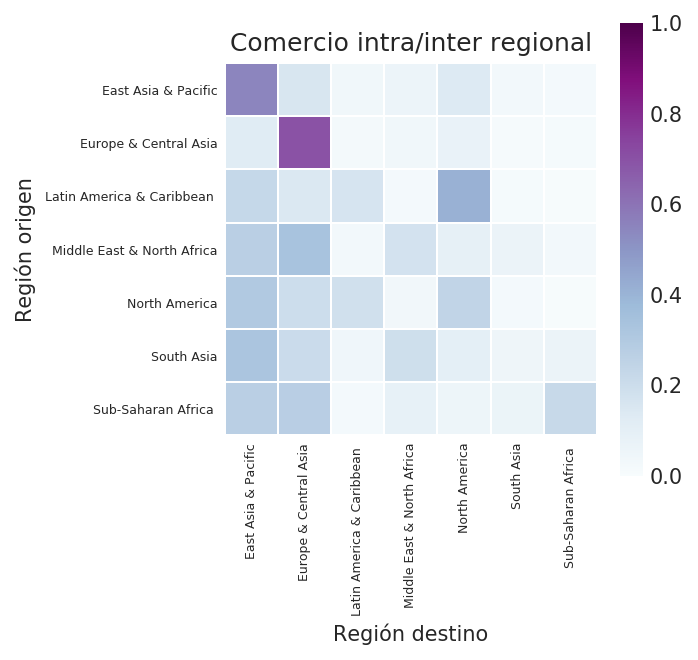

In [96]:

plt.figure(figsize=(4, 4), dpi=150);
ax = sns.heatmap(grp_by_reg,
            vmin=0, vmax=1,
            cmap="BuPu",
            linewidths=0.5,
            square=True);

ax.set_xlabel("Región destino")
ax.set_ylabel("Región origen")
ax.set_title("Comercio intra/inter regional")
ax.set_xticklabels(grp_by_reg.columns, fontdict=dict(size=6))
ax.set_yticklabels(grp_by_reg.index.values, fontdict=dict(size=6));


Podemos leer el gráfico de la siguiente manera: las celdas con colores oscuros indican un mayor volumen de transacciones entre esa pareja de zonas. La diagonal corresponde con los intercambios con origen y destino en la misma zona. Podemos observar que sólo en el caso de *Asia Oriental y Pacífico* y de *Europa y Asia Central*, los intercambios internos tienen una importancia superior a los externos. Si bien hablamos de intercambios internacionales en cualquier caso, y teniendo en cuenta que nos hemos normalizado los valores por distancia geográfico, podemos deducir que los países de las citadas regiones tienen a comerciar más con los países de su entorno.

En cuanto a los valores altos fuera de la diagonal saltan a la vista dos celdas: *Medio Oriente y África Septentrional* comercia principalmente con *Europa y Asia Central*, mientras que *América Latina y el Caribe* comercia sobre todo con *Norteamérica*. Si bien estos países están asignados a zonas geográficas distintas, la cercanía geográfica es relevante, ya que, por ejemplo, Sudamérica genera más intercambios con su vecina Norteamérica que con Europa.

### ¿Hay países que monopolizan la exportación de ciertos bienes?

Estos datos también nos pueden informar de cómo de monopolizados están ciertas materias primas y bienes manufacturados. Un análisis de este tipo nos permite extraer información sobre la dependencia que tenemos de ciertos países. Paralelamente, podríamos detectar si hay países que centralizan la compra de ciertos bienes.

En este caso nos vamos a centrar en las exportaciones. Para ello, realizaremos las siguientes operaciones:
- Agruparemos las exportaciones por categorías y por países y obtendremos el volumen y el porcentaje de volumen que corresponde a cada país dentro de cada categoría.
- Obtendremos los productos más monopolizados, es decir, aquellos en los que un país acapara un mayor porcentaje del volumen total de dicho producto
- Asímismo, para poder comparar, obtendremos los productos con un mercado más segmentado. Podremos detectarlos a partir de la desviación estándar de los porcentajes de volumen de cada categoría. Alternativemente podríamos usar la diferencia entre el país con mayor porcentaje y con menos, pero usando la desviación aplicamos sólo un groupby en vez de dos.



In [405]:
# primer groupby: volumen total por producto y país
grp_by_cat = (df[df['Direction'] == "Export"]
              .groupby(by=["CommodityCode", "Source"], as_index=False)
              .sum()[['CommodityCode', 'Source', 'TradeValue']])
# segundo groupby: porcentaje del volumen que aporta cada país a cada producto
grp_by_cat["TradeValuePercent"] = (grp_by_cat
                                   .groupby('CommodityCode')
                                   .transform(lambda x: x / x.sum()))
# finalmente: añadimos las descripciones de nuevo (perdidas en el groupby) y descartamos columnas innecesarias
grp_by_cat = (grp_by_cat
              .merge(commodities,
                     how='inner',
                     left_on="CommodityCode",
                     right_on="Code"))[['Source', 'Code', 'TradeValuePercent', 'Description']]
              

In [406]:
# Estos son los países que más acaparan un producto concreto. No sorprende a nadie que China monopolice
# muchas materias primas y bienes de consumo
grp_by_cat.sort_values(by="TradeValuePercent", ascending=False).head(5)

,Source,Code,TradeValuePercent,Description
8772,China,66.0,0.811892,"Umbrellas, sun umbrellas, walking-sticks, seat..."
8893,China,67.0,0.777564,Prepared feathers and down and articles made o...
6161,China,46.0,0.691768,"Manufactures of straw, of esparto or of other ..."
6102,Portugal,45.0,0.628626,Cork and articles of cork
8637,China,65.0,0.551424,Headgear and parts thereof


In [431]:
(grp_by_cat
 .groupby(by=["Code"], as_index=True)
 .std()
 .merge(commodities,
        how='inner',
        left_index=True,
        right_on="Code")
 .sort_values(by="TradeValuePercent", ascending=True)
 .head(5))

,TradeValuePercent,Code,Description
24,0.013485,25.0,Salt; sulphur; earths and stone; plastering ma...
23,0.015673,24.0,Tobacco and manufactured tobacco substitutes
10,0.016285,11.0,Products of the milling industry; malt; starch...
18,0.016692,19.0,"Preparations of cereals, flour, starch or milk..."
43,0.016734,44.0,Wood and articles of wood; wood charcoal


[3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 6.0]
[3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 6.0]
[3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0]
[3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0]


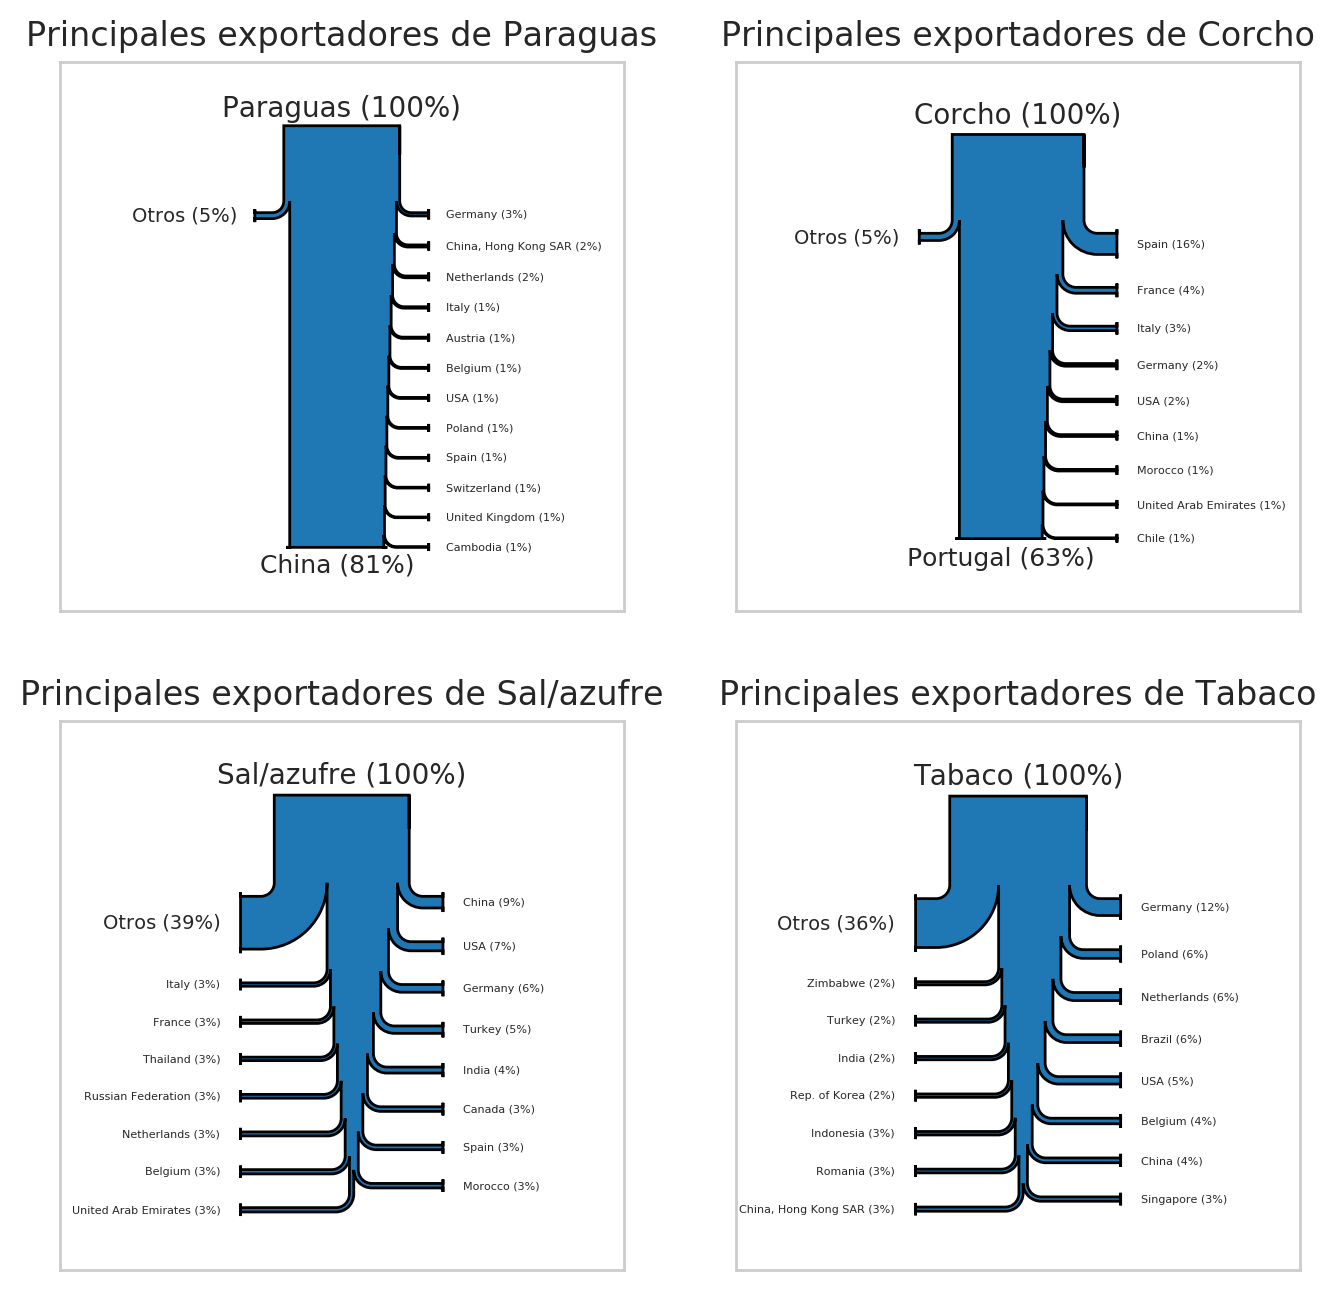

In [441]:
from matplotlib.sankey import Sankey

plot_commodities = {
    66: "Paraguas",
    45: "Corcho",
    25: "Sal/azufre",
    24: "Tabaco"    
}

i = 0

fig = plt.figure(figsize=(8, 8), dpi=200)

for code, title in plot_commodities.items():
    i = i+1
    
    comm_summary = grp_by_cat[grp_by_cat['Code'] == code].sort_values(by="TradeValuePercent", ascending=False)
    comm_summary['TradeValueCumulative'] = comm_summary.cumsum()['TradeValuePercent']
    comm_summary = comm_summary[comm_summary['TradeValueCumulative'] < 0.95]
    if comm_summary.shape[0] > 15:
        comm_summary = comm_summary.iloc[0:15]
        
        flows = list([100])
        flows.extend(-(comm_summary['TradeValuePercent'].values * 100))
        flows.append(-(sum(flows)))

        labels = list([title])
        labels.extend(comm_summary['Source'].values)
        labels.append("Otros")
        labels = ["{0} ({1:.0f}%)".format(l, abs(f)) for l, f in zip(labels, flows)]

        orientations = list([0])
        orientations.extend([1] * ((comm_summary.shape[0] //2)+1))
        orientations.extend([-1] * (len(flows)-len(orientations)))
    else:
        flows = list([100])
        flows.extend(-(comm_summary['TradeValuePercent'].values * 100))
        flows.append(-(sum(flows)))

        labels = list([title])
        labels.extend(comm_summary['Source'].values)
        labels.append("Otros")
        labels = ["{0} ({1:.0f}%)".format(l, abs(f)) for l, f in zip(labels, flows)]

        orientations = list([0, 0])
        orientations.extend([1] * (comm_summary.shape[0]-1))
        orientations.append(-1)

    
    ax = fig.add_subplot(2, 2, i, xticks=[], yticks=[], title="Principales exportadores de " + title)
    sankey = Sankey(ax=ax, scale=0.01, offset=0.15, head_angle=180, unit=None)
    sankey.add(flows=flows,
               labels=labels,
               orientations=orientations,
               rotation=270)
    diagrams = sankey.finish();
    

    for j in range(1,len(labels)):
        if(diagrams[0].angles[j] == 4):
            diagrams[0].texts[j].set_ha('left')
        else:
            diagrams[0].texts[j].set_ha('right')
        if (j == len(labels)-1):
            diagrams[0].texts[j].set_size(7)
        else:
            diagrams[0].texts[j].set_size(4)
        if j == 1 and len(flows)<16:
            diagrams[0].texts[j].set_size(9)
            diagrams[0].texts[j].set_ha('center')
        
